# Word bigrams as a scale-free network

In this notebook, we analyze the directed graph of words with edges weighted by bigram counts in a text corpus.
The notebook was created by following both the [NetworkX reference](https://networkx.github.io/documentation/stable/reference/index.html) and the [NetworKit User Guide](http://nbviewer.jupyter.org/urls/networkit.iti.kit.edu/uploads/docs/NetworKit_UserGuide.ipynb).

In [1]:
import logging
logging.basicConfig(level=logging.DEBUG, format="%(asctime)s: (%(lineno)s) %(levelname)s %(message)s")

%matplotlib inline
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 6)

import networkx as nx

Populating the interactive namespace from numpy and matplotlib


## Reading and exploring the graph

Let us start by reading the network.

In [2]:
G = nx.read_gpickle('/mnt/permanent/home/makrai/project/TextBetweenness/mnsz2_1k-sent.gpickle')

G is a directed graph, *Di*Graph:

In [3]:
type(G)

networkx.classes.digraph.DiGraph

In [4]:
G.is_directed()

True

In this graph, nodes are python strings representing Hungarian words. 

In [ ]:
w1, w2 = 'az', 'ember'

In [25]:
G.has_edge(w1, w2)

True

The bigram frequency of _a kutya_ `the dog' corresponds to an edge weigth:

In [24]:
try:
    print(G[w1][w2])
except:
    logging.warn('"{} {}" not in corpus'.format(w1, w2))

{'weight': 3}


The reverse bigram is much less frequent:

In [26]:
try:
    print(G[w2][w1])
except:
    print('This small sample does not contain the reverse bigram.')

This small sample does not contain the reverse bigram.


In [8]:
G.number_of_nodes(), G.number_of_edges()

(6828, 12952)

## Connected Components

A strongly connected component (SCC) is a set of nodes in which each pair of nodes is connected by a directed path. 
The following function determines the SCCs of a graph:

### Connectivity

2017-12-30 09:16:48.010941
False
5
1 ['Jancsi']
1 ['Kukorica']
6824 ['csata', 'kettes', 'csodákat', 'figyelmeztetése', 'éltek', 'ajtaját', 'három-négy', 'lanyok']
1 ['Bandini']
1 ['Lorenzo']
2017-12-30 09:16:48.509657


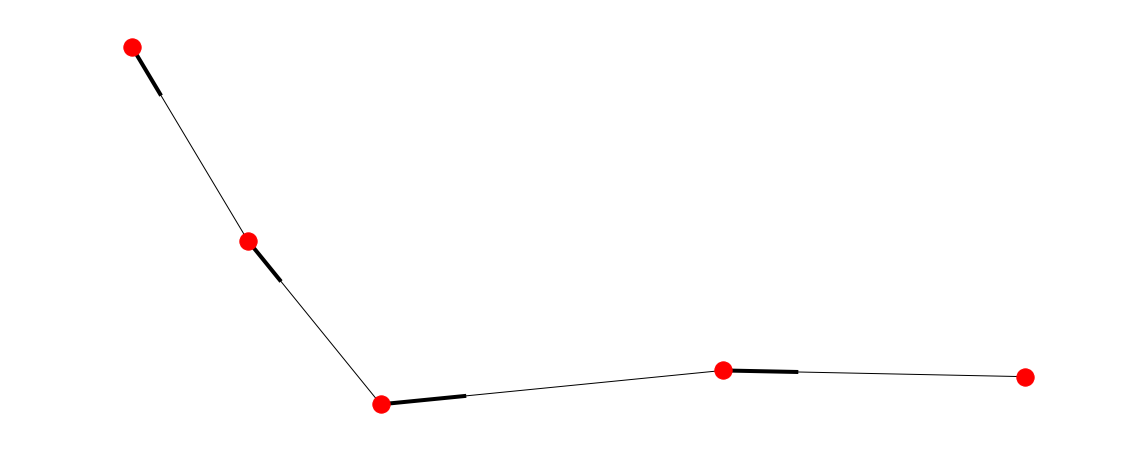

In [9]:
import datetime
print(datetime.datetime.now())
is_sconn = nx.is_strongly_connected(G)
print(is_sconn)
if not is_sconn:
    print(nx.number_strongly_connected_components(G))
    for cmp in nx.strongly_connected_components(G):
        print(len(cmp), list(cmp)[:8])
    nx.draw(nx.condensation(G))
print(datetime.datetime.now())



Time coplexity of `is_strongly_connected`:

| # sentences | time          |
|-------------|---------------|
|10 k         |3 sec          |
|30 k         |20 sec         |
|100 k        |2 min          |

## Degree Distribution

In our case, node degree is the occurrence count of the corresponding word. We start with this simple measure.

Node degree, the number of edges connected to a node, is one of the most studied properties of networks. Types of networks are often characterized in terms of their distribution of node degrees. We obtain and visualize the degree distribution of our example network as follows.  

In [10]:
import operator

def sort_by_value(dict_):
    return sorted(dict_.items(), key=operator.itemgetter(1), reverse=True)

In [11]:
dcent = sort_by_value(nx.centrality.degree_centrality(G))

In [12]:
dcent[:10]

[(',', 0.20697231580489234),
 ('a', 0.19071334407499635),
 ('.', 0.1457448366778966),
 ('az', 0.07587520140618134),
 ('és', 0.05097407353156584),
 ('nem', 0.02914896733557932),
 ('A', 0.02914896733557932),
 ('is', 0.028563058444411895),
 ('-', 0.025926468434158488),
 (':', 0.024754650651823643)]

In [13]:
def plot_word_values(items_sorted, cutoff=20):
    words, cents = zip(*items_sorted)
    logging.info(words[:100])
    plt.bar(range(cutoff), cents[:cutoff], align='center')
    plt.xticks(range(cutoff), words[:cutoff])
    plt.show()

2017-12-30 09:16:48,738: (3) INFO (',', 'a', '.', 'az', 'és', 'nem', 'A', 'is', '-', ':', 'egy', '(', ')', '"', 'hogy', '?', 'Az', 'meg', 'van', 'vagy', 'már', 'volt', 'azt', '!', 'kell', 'még', 'szerint', 'csak', 'el', 'olyan', 'ez', 'ha', 'között', 'pedig', 'nagyon', 'ki', 'ezt', 'de', 'új', 'minden', 'mint', 'akkor', 'így', '...', '&verbar;', 'magyar', 'majd', 'úgy', ';', 'Nem', 'be', 'lesz', 'után', 'lehet', 'Ez', 'Magyar', 'miatt', '=', 'sem', 'fel', 'azonban', 'mi', 'több', 'mert', 'két', 'jól', 's', 'itt', 'annak', 'arra', 'nagy', 'lenne', 'én', 'mellett', '-e', 'ma', 'azért', 'most', 'éves', 'nincs', 'más', 'millió', 'volna', 'felé', 'saját', 'erre', '3', '1', 'amely', 'tett', '2', 'le', 'által', 'ilyen', 'ami', 'ő', 'ember', 'magát', 'első', 'De')


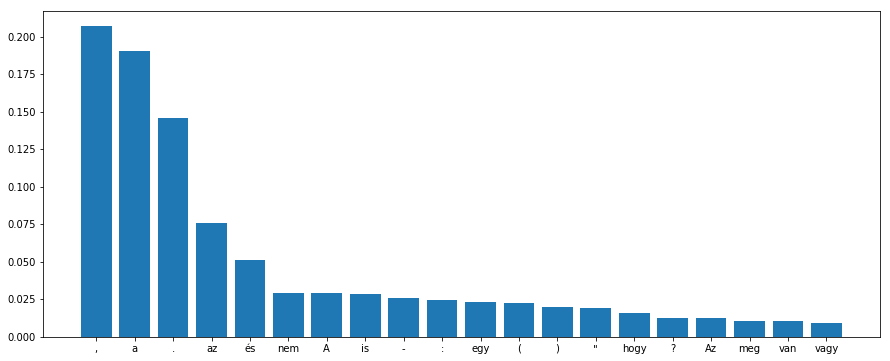

In [14]:
plot_word_values(dcent)

In [15]:
def loglog_word_values(cents):
    plt.loglog(range(len(cents)), cents)

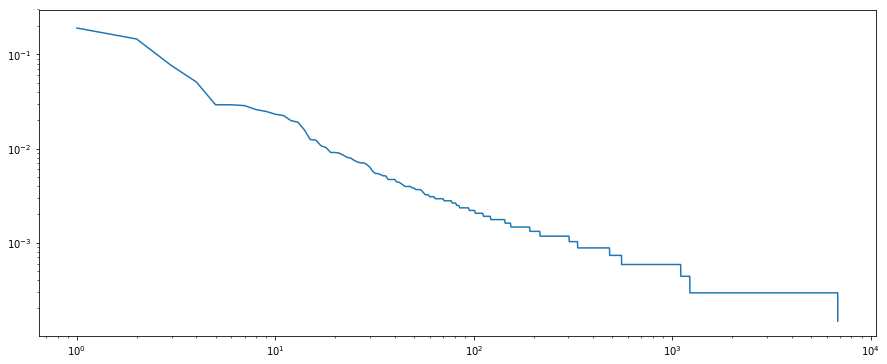

In [16]:
words, cents = zip(*dcent)
loglog_word_values(cents)

We choose a logarithmic scale on both axes because a _powerlaw degree distribution_, a characteristic feature of complex networks, would show up as a straight line from the top left to the bottom right on such a plot. As we see, the degree distribution of the `PGPgiantcompo` network is definitely skewed, with few high-degree nodes and many low-degree nodes. But does the distribution actually obey a power law? In order to study this, we need to apply the [powerlaw](https://pypi.python.org/pypi/powerlaw) module. Call the following function:

In [17]:
import powerlaw
fit = powerlaw.Fit(cents)

Calculating best minimal value for power law fit
/home/makrai/tool/python/venv3/lib/python3.5/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


The powerlaw coefficient can then be retrieved via:

In [18]:
fit.alpha

2.201680988765367

If you further want to know how "good" it fits the power law distribution, you can use the the `distribution_compare`-function. From the documentation of the function: 
> R : float
>
> Loglikelihood ratio of the two distributions' fit to the data. If
> greater than 0, the first distribution is preferred. If less than
> 0, the second distribution is preferred.

> p : float
>
> Significance of R


In [19]:
fit.distribution_compare('power_law','exponential')

/home/makrai/tool/python/venv3/lib/python3.5/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


(132.91443372333427, 5.9125052707187189e-06)

## Distance Measures, ,,small world''

The _eccentricity_ of a node $v$ is the maximum distance from $v$ to all other nodes in $G$.

In [28]:
logging.info('')
ecc_d_l = [nx.eccentricity(comp) for comp in nx.strongly_connected_component_subgraphs(G)]
logging.info('')

2017-12-30 10:37:09,935: (1) INFO 
2017-12-30 10:41:15,458: (3) INFO 


|sentences|time |
|:-------:|:---:|
|1K|4 min 15 sec|

In [29]:
ecc_d = ecc_d_l[2]
#ecc_d

The _radius_ is the minimum eccentricity.

In [30]:
nx.radius(G, ecc_d) #usebounds=True does not cause a difference

9

The diameter is the maximum eccentricity.

In [31]:
nx.diameter(G, ecc_d)

19

The _center_ is the set of nodes with eccentricity equal to radius.

In [32]:
nx.center(G, ecc_d)

[',']

The _periphery_ is the set of nodes with eccentricity equal to the diameter:

In [33]:
nx.periphery(G, ecc_d)

['Megadható', 'two']

## Transitivity / Clustering Coefficients
### (not very meaningful for DiGraphs)

In the most general sense, transitivity measures quantify how likely it is that the relations out of which the network is built are transitive. The clustering coefficient is the most prominent of such measures. We need to distinguish between global and local clustering coefficient: The global clustering coefficient for a network gives the fraction of closed triads. The local clustering coefficient focuses on a single node and counts how many of the possible edges between neighbors of the node exist. The average of this value over all nodes is a good indicator for the degreee of transitivity and the presence of community structures in a network, and this is what the following function returns:

### Compute graph transitivity, the fraction of all possible triangles present in G

In [34]:
logging.info('')
print(nx.transitivity(G))
logging.info('')

2017-12-30 10:41:15,498: (1) INFO 
2017-12-30 10:41:16,124: (3) INFO 


0.0026300923465821372


### Compute the clustering coefficient for nodes.

`clustering`, `average_clustering` are not implemented for directed graphs, see [Malliaros (arXiv)](https://arxiv.org/pdf/1308.0971).


#### Compute the squares clustering coefficient for nodes

While $C_3(v)$ (triangle clustering) gives the probability that two neighbors of node v are connected with each other, $C_4(v)$ is the probability that two neighbors of node $v$ share a common neighbor different from $v$. This computation takes a long time.

`sq_clus` is of type `{'the': .4}`

#### Compute the generalized degree for nodes

`generalized_degree` is not implemented for directed graphs


For each node, the _generalized degree_ shows how many edges of given triangle multiplicity the node is connected to. The _triangle multiplicity_ of an edge is the number of triangles an edge participates in. The generalized degree of node i can be written as a vector $\mathbf{k}_i=(k_i^{(0)}, \dotsc, k_i^{(N-2)})$ where $k_i^{(j)}$ is the number of edges attached to node $i$ that participate in $j$ triangles.

## Traversal (search) and Shortest Paths

### Depth First Search

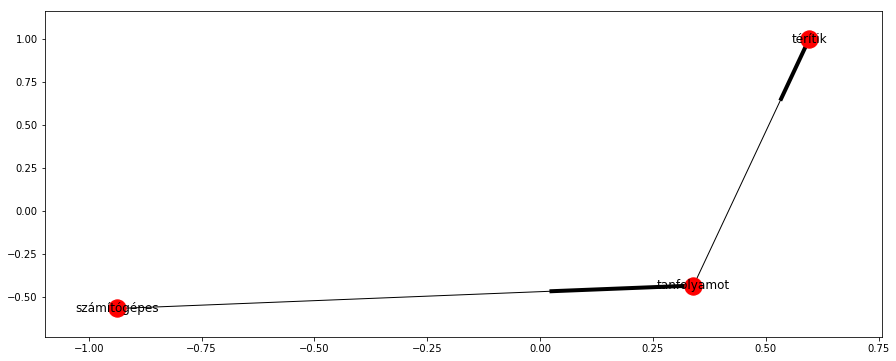

In [35]:
nx.draw_networkx(nx.subgraph(G, nx.traversal.dfs_postorder_nodes(G, 'számítógépes', 3)))

### Shortest Paths 

**TODO** approximation

These algorithms work with undirected and directed graphs.

In [36]:
nx.shortest_path(G, 'számítógépes', 'nyelvészeti')

NodeNotFound: Either source számítógépes or target nyelvészeti is not in G

In [ ]:
nx.shortest_path(G, 'számítógépes', 'nyelvészeti', weight='weight')

#### Unweighted graphs

#### Weighed graphs

#### Dense Graphs: Floyd-Warshall algorithm

#### A* Algorithm

Computing the length of the shortest path between source and target using the A* (“A-star”) algorithm.

nx.astar_path_length(G, source, target[, …]) 	

In [ ]:
nx.distance_measures.bfs_beam_edges(G, 'magyar', )

### Depth First Search on Edges

## Betweenness

In [37]:
G.number_of_nodes()

6828

In [38]:
def head(dict_):
    items = sort_by_value(dict_)[:1000]
    keys, _ = zip(*items)
    return keys, dict(items)

In [90]:
def plot_against_degree(cent, background=None, annot_prob=.1, deg_limit=.004, x_limit=.003):
    if background is None:
        background = nx.degree_centrality(G)
    ws_dg, dgr = head(background)
    ws_bt, btw = head(cent)
    ws = [w for w in ws_dg if w in ws_bt]
    plt.xscale('log')
    plt.yscale('log')
    plt.scatter(
        [dgr[wd] for wd in ws],
        [btw[wd] for wd in ws])
    for wd in ws:
        if random.random() < annot_prob or dgr[wd] > deg_limit or btw[wd] > x_limit:
            
            plt.annotate(wd, (dgr[wd], btw[wd]), rotation=45)

### The number of word types before and after the node

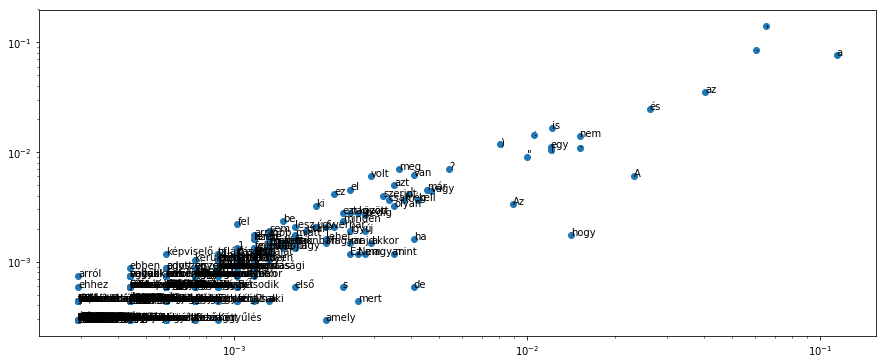

In [40]:
plot_against_degree(nx.in_degree_acentrality(G), background=nx.out_degree_centrality(G))


### (Shortest Path) Betweenness

2017-12-30 13:34:12,339: (2) INFO 50


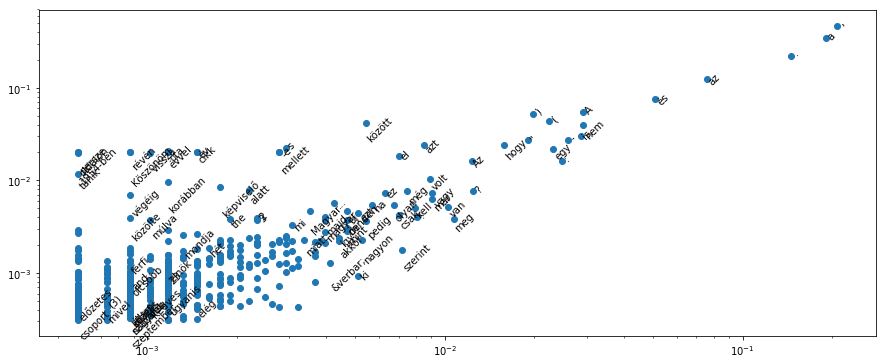

In [125]:
samp_siz = 50
logging.info(samp_siz)
plot_against_degree(
    nx.betweenness_centrality(G, samp_siz, normalized=True),
    annot_prob=.05)

### Current Flow Betweenness

not implemented for directed type

_Current-flow betweenness_ centrality uses an electrical current model for information spreading in contrast to betweenness centrality which uses shortest paths.

Current-flow betweenness centrality is also known as _random-walk betweenness_ centrality [2].

### Communicability Betweenness

not implemented for directed type

Communicability betweenness measure makes use of the number of walks connecting every pair of nodes as the basis of a betweenness centrality measure.

## Centrality (but not betweenness?)

### Eigenvector

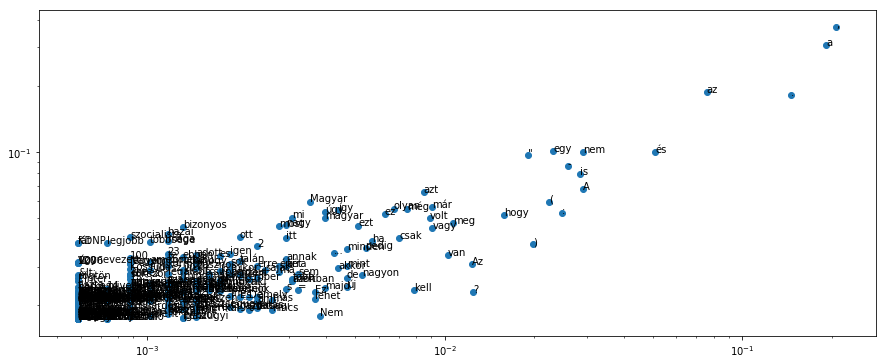

In [42]:
plot_against_degree(nx.eigenvector_centrality(G))

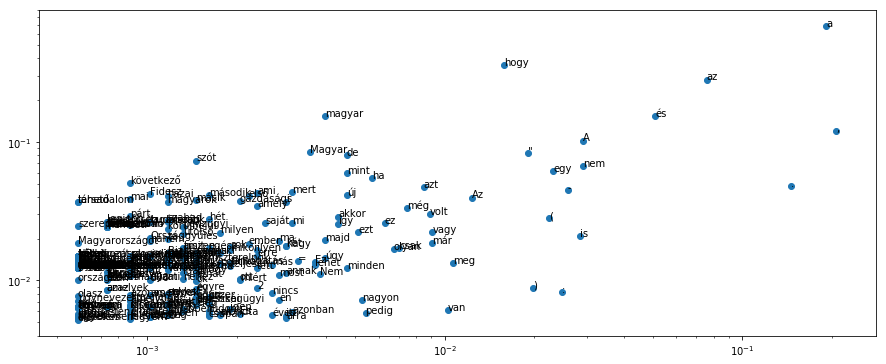

In [43]:
plot_against_degree(nx.eigenvector_centrality(G, weight='weight'))

### Closeness

In [44]:
H = G.to_undirected()

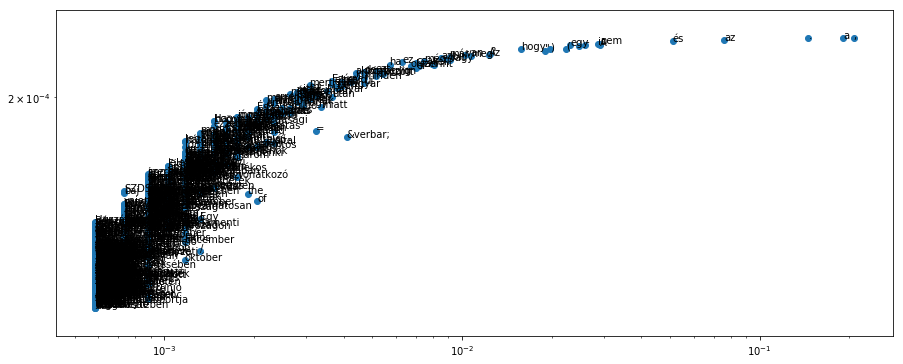

In [45]:
plot_against_degree(nx.current_flow_closeness_centrality(H))

### PageRank

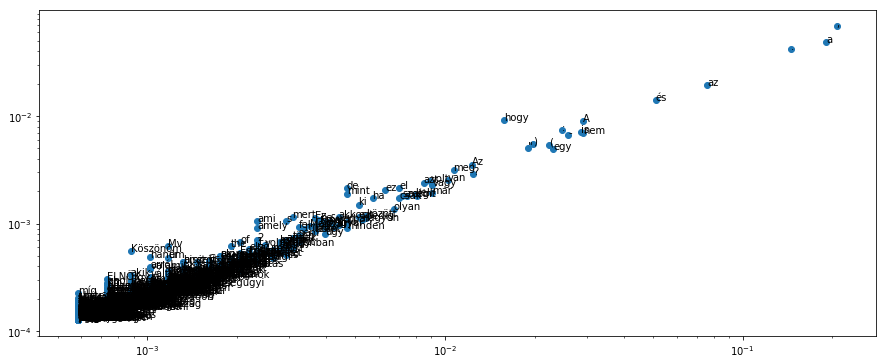

In [46]:
plot_against_degree(nx.algorithms.link_analysis.pagerank(G))

### HITS

The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.

In [47]:
hs = nx.algorithms.link_analysis.hits(G)

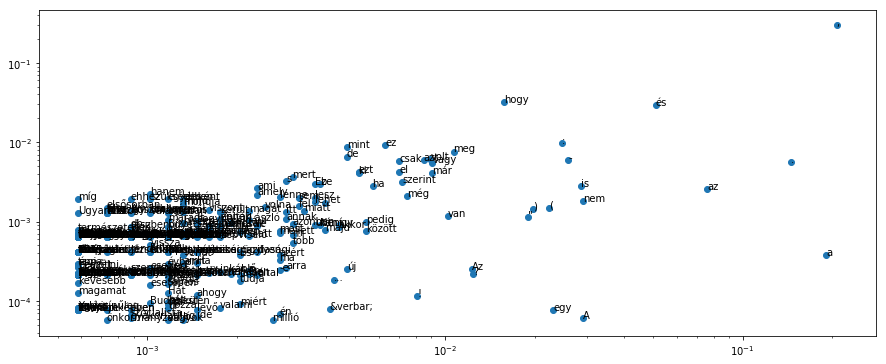

In [48]:
plot_against_degree(hs[0])

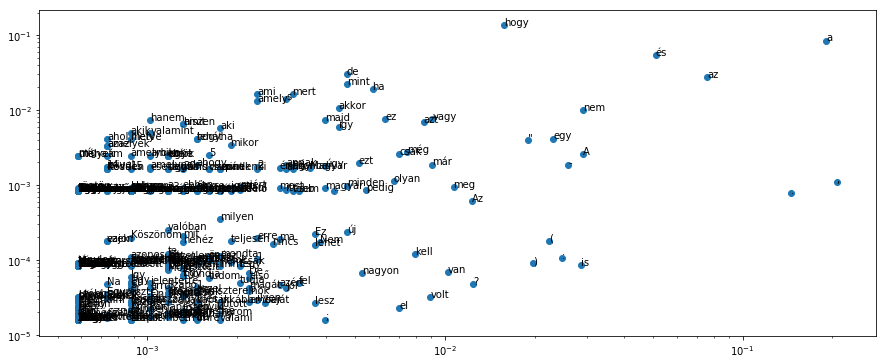

In [49]:
plot_against_degree(hs[1])

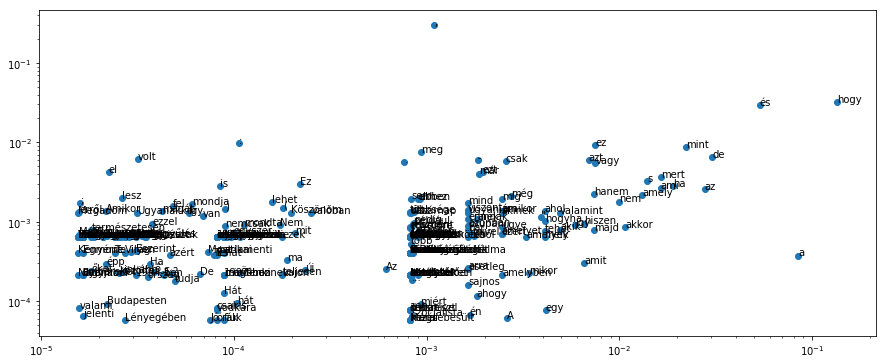

In [50]:
plot_against_degree(hs[0], background=hs[1])

## Core Decomposition

A $k$-core decomposition of a graph is performed by successicely peeling away nodes with degree less than $k$. The remaining nodes form the $k$-core of the graph.

Core decomposition assigns a core number to each node, being the maximum $k$ for which a node is contained in the $k$-core.

Self loops are not permitted, so we remove these edges:

In [51]:
G_no_loop = G.copy()

In [52]:
G_no_loop.remove_edges_from(nx.selfloop_edges(G_no_loop))

In [53]:
coren = nx.core_number(G_no_loop)

In [54]:
from collections import defaultdict

def print_by_value(coren, max_by_val=8):
    words_by_core_num = defaultdict(set)
    for w, c in coren.items():
        words_by_core_num[c].add(w)
    for cr in range(max(words_by_core_num.keys()) + 1):
        if words_by_core_num[cr]:
            print(cr, len(words_by_core_num[cr]), list(words_by_core_num[cr])[:max_by_val])

In [55]:
print_by_value(coren)        

1 4 ['Kukorica', 'Jancsi', 'Lorenzo', 'Bandini']
2 6073 ['csata', 'csodákat', 'kettes', 'figyelmeztetése', 'éltek', 'ajtaját', 'három-négy', 'lanyok']
3 416 ['védelme', 'állam', 'Ezt', 'gondolom', '1938-ban', 'kapcsolatos', '(1)', 'ismert']
4 151 ['egyre', 'teljesen', 'tudják', 'nagyszerűen', 'megfelelően', 'nehéz', 'sok', 'valamint']
5 68 ['Hát', 'hasznos', 'amerikai', 'te', 'más', 'Már', '-,', 'rendelkezik']
6 28 ['lenne', 'legalább', 'szó', '2.', 'Csak', 'annak', 'ezzel', 'jó']
7 30 ['...', '&verbar;', 'lesz', 'fel', '3', ';', 'hát', 'például']
8 26 ['minden', 'pedig', 'Ez', 'ő', 'azonban', 'És', 'mint', '?']
9 13 ['itt', 'ha', 'mi', 'volt', 'még', ':', 'vagy', 'mert']
10 19 ['.', 'így', 'ezt', 'egy', 'meg', 'ez', 'is', 'akkor']


Weights?

## Clicques

The nodes of the maximal clique graph of G are the maximal (with respect to containment, not size) cliques of G and an edge joins two cliques if the cliques are not disjoint.

not implemented for directed type

In [56]:
H = G.to_undirected()

In [57]:
mcg = nx.make_max_clique_graph(H)

In [58]:
mcg.number_of_nodes()

10793

In [59]:
mcg.number_of_edges()

3194101

In [60]:
nx.graph_clique_number(H)

8

|# sentence|clique number|
|--------|-------------|
|1k|8|

The size of the largest maximal clique containing each given node:

In [61]:
print_by_value(nx.node_clique_number(H))

2 5188 ['védelme', 'vért', 'csata', 'Horváth', 'csodákat', 'kettes', 'háttere', 'távközlési']
3 1413 ['zsarolgatunk', 'Krivaja-patakba', 'állam', 'mentek', 'gondolom', 'megpofoztam', 'termékünk', 'zavarosban']
4 145 ['teljesen', 'tudják', 'lenne', 'embereket', 'megfelelően', 'nehéz', 'sok', 'segítségével']
5 45 ['...', 'lesz', 'fel', 'vagy', 'van', 'például', 'amely', 'ő']
6 22 ['mi', 'pedig', ':', 'Ez', ')', 'ha', 'mint', 'mondja']
7 7 ['.', 'még', 'is', '-', 'azt', 'már', 'és']
8 8 ['meg', 'ezt', 'az', ',', 'hogy', 'a', 'nem', 'lehet']


The number of maximal cliques for each node:

In [62]:
print_by_value(nx.number_of_cliques(H))

1 989 ['zsarolgatunk', 'Krivaja-patakba', 'másikéról', 'igazságszolgáltatás', 'jelentőségét', 'namam', 'Gyulai', 'megpofoztam']
2 4703 ['vért', 'csata', 'csodákat', 'kettes', 'gondolom', 'háttere', 'távközlési', 'éltek']
3 302 ['címmel', 'egyetemi', 'királyok', 'nagyszerűen', 'Baszk', 'mentek', 'cáfolta', 'megpróbál']
4 361 ['védelme', 'magamat', '1938-ban', 'ismert', 'jelent', 'kapcsolatban', 'kérdéseire', 'helyen']
5 100 ['mai', 'kialakult', 'valamint', 'Már', 'ellátás', 'fenn', 'révén', 'hétfőn']
6 107 ['állam', 'Horváth', 'megfelelően', 'te', 'intézet', 'forintot', 'erről', 'nappal']
7 43 ['nehéz', 'legalább', 'hát', 'kapcsolatos', 'akár', 'hasonló', 'elnök', 'vagyunk']
8 52 ['Hát', 'valaki', 'János', 'amerikai', 'száma', 'újabb', 'szó', 'pénzügyi']
9 21 ['ide', 'miniszter', '1.', 'egyre', 'másik', 'hasznos', '/', 'e']
10 19 ['jutott', 'igen', 'ott', 'négy', 'került', 'inkább', 'néhány', 'százalékos']
11 15 ['milyen', 'második', 'teljesen', 'támogatás', 'tudja', 'the', 'sok', 'miér

In [63]:
nx.cliques_containing_node(H, nodes=['levéltárosok'])

{'levéltárosok': [['Nem', 'levéltárosok'], ['levéltárosok', 'Magyar']]}

In [64]:
nx.algorithms.community.kclique.k_clique_communities

<function networkx.algorithms.community.kclique.k_clique_communities>

## Community Detection

This section demonstrates community detection. Community detection is concerned with identifying groups of nodes which are significantly more densely connected to eachother than to the rest of the network.

In [65]:
from networkx.algorithms import community

### Bipartitions to reduce the edge cut between the two sets

### K-Clique

A k-clique community is the union of all cliques of size $k$ (here $k=6$) that can be reached through adjacent (sharing k-1 nodes) k-cliques.

In [66]:
comm = list(community.k_clique_communities(H, 6))[0]

In [67]:
type(comm), len(comm)

(frozenset, 37)

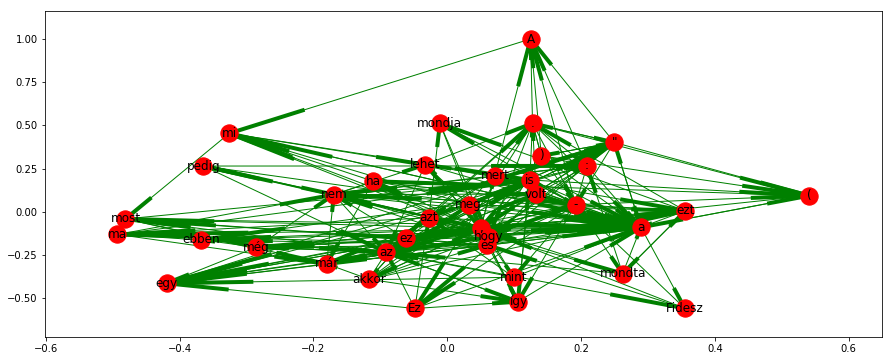

In [68]:
nx.draw_networkx(nx.subgraph(G, nbunch=comm), edge_color='g')

### Label propagation

Asynchronous label propagation algorithms for community detection.

### Fluid Communities

Asynchronous Fluid Communities algorithm for community detection.

Here, $k$ is number of communities to be found.

In [69]:
import random

for k in range(2,10):
    print(k)
    partition_ = community.asyn_fluidc(H, k)
    for val in partition_:
        print(len(val), list(val)[:5])
    #print(community.performance(H, partition_)) error. because directed?

2
2878 ['Krivaja-patakba', 'Horváth', 'mentek', 'kettes', 'megpofoztam']
3950 ['zsarolgatunk', 'védelme', 'vért', 'állam', 'csata']
3
2667 ['állam', 'csata', 'mentek', 'gondolom', 'járnak']
2897 ['zsarolgatunk', 'Krivaja-patakba', 'védelme', 'vért', 'kettes']
1264 ['dinoszauruszok', 'asszociativitásából', 'Anadolu', 'tettére', 'görögül']
4
1345 ['védelme', 'igazságszolgáltatás', 'gonoszság', 'csata', 'állam']
1919 ['Horváth', 'gondolom', 'megpofoztam', 'háttere', 'távközlési']
2203 ['Krivaja-patakba', 'figyelmeztetése', 'járnak', 'csoportot', 'oldalról']
1361 ['zsarolgatunk', 'vért', 'namam', 'asszociativitásából', 'Ezt']
5
1784 ['védelme', 'állam', 'megpofoztam', 'háttere', 'figyelmeztetése']
1626 ['zsarolgatunk', 'Krivaja-patakba', 'vért', 'csata', 'Horváth']
1003 ['tűnt', 'menedzsmentjeik', 'ezekkel', 'Gyulai', 'viselkedése']
1529 ['mentek', 'zavarosban', 'csoportot', 'oldalról', 'Népszabadság']
886 ['magamat', 'éjszaka', 'Kolozsvár', 'csodákat', 'rontja']
6
991 ['egyre', 'módón', '

### Partitions via centrality measures

*Modularity* is the primary measure for the quality of a community detection solution. The value is in the range `[-0.5,1]` and usually depends both on the performance of the algorithm and the presence of distinctive community structures in the network.

### The distribution of community sizes

...has nothing to do with powerlaw. Should it?

## Assortativity

In [70]:
nx.degree_assortativity_coefficient(G)

-0.20221710216804981

In [71]:
nx.attribute_assortativity_coefficient(G, 'weight')

/home/makrai/tool/python/venv3/lib/python3.5/site-packages/networkx/algorithms/assortativity/correlation.py:264: RuntimeWarning: invalid value encountered in true_divide
  r=(t-s)/(1-s)


nan

Compute assortativity for numerical node attributes:

In [72]:
nx.degree_pearson_correlation_coefficient(G)

-0.20221710216804992

### Average neighbor degree

The average degree of the neighborhood of each node:

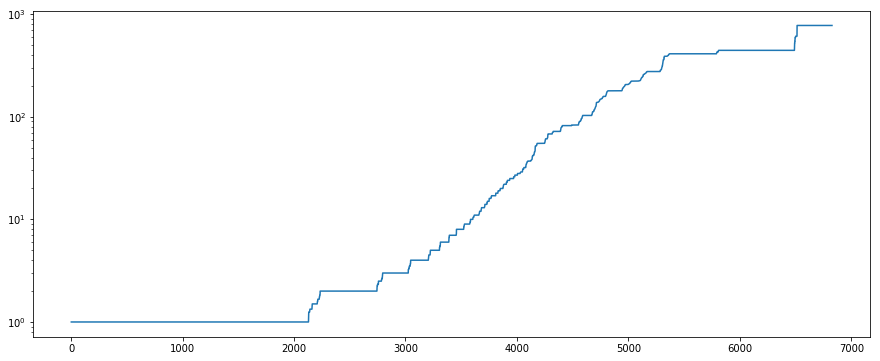

In [73]:
plt.semilogy(sorted(nx.average_neighbor_degree(G).values()))
#plt.yscale('log')

### Average degree connectivity

The _average degree connectivity_ is the average nearest neighbor degree of nodes with degree k. For weighted graphs, an analogous measure can be computed using the weighted average neighbors degree defined in [1], for a node i, as
kwnn,i=1si∑j∈N(i)wijkj

where s_i is the weighted degree of node i, w_{ij} is the weight of the edge that links i and j, and N(i) are the neighbors of node i.

A dictionary keyed by degree $k$ with the value of average connectivity.

In [74]:
def plot_avg_deg_conn(adc):
    dg, cn = zip(*adc.items())
    plt.scatter(dg, cn)

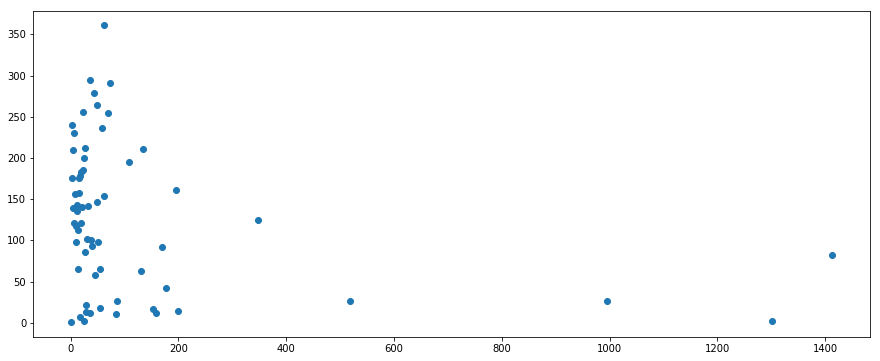

In [75]:
plot_avg_deg_conn(nx.average_degree_connectivity(G, weight='weight'))

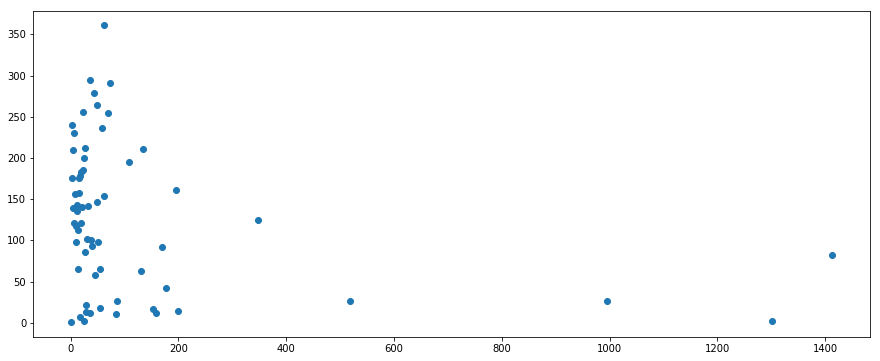

In [76]:
plot_avg_deg_conn(nx.k_nearest_neighbors(G, weight='weight'))

### Mixing

Mixing patterns refer to systematic tendencies of one type of nodes in a network to connect to another type. For instance, nodes might tend to link to others that are very similar or very different. This feature is common in many social networks, although it also appears sometimes in non-social networks.

In [77]:
nx.attribute_mixing_matrix(G, 'weight')

array([[ 1.]])

In [93]:
dmm = nx.degree_mixing_matrix(G)

/home/makrai/tool/python/venv3/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


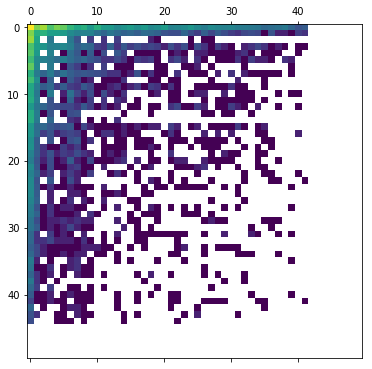

In [123]:
import numpy as np
b = np.sum(dmm, axis = 0)
idx = (-b).argsort()
c = np.sum(dmm, axis=1)
idx2 = (-c).argsort()
#plt.matshow
top=50
plt.matshow(np.log(dmm[idx2[:top],:][:,idx[:top]]))
#dmm.shape
#np.sum(dmm, axis=1).argsort()
#np.take([np.argmax(dmm, axis=0), np.argmax(dmm, axis=0)]

In [79]:
nx.degree_mixing_dict(G)

{1: {1: 1967,
  2: 460,
  3: 230,
  4: 148,
  5: 88,
  6: 57,
  7: 49,
  8: 63,
  9: 34,
  10: 35,
  11: 24,
  12: 22,
  13: 24,
  14: 33,
  15: 9,
  16: 15,
  18: 7,
  19: 28,
  22: 21,
  23: 12,
  25: 32,
  27: 21,
  28: 31,
  30: 17,
  31: 31,
  34: 13,
  41: 43,
  42: 19,
  48: 61,
  62: 38,
  71: 54,
  74: 38,
  76: 29,
  80: 65,
  96: 43,
  97: 65,
  112: 59,
  169: 125,
  242: 118,
  526: 314,
  584: 423,
  969: 682},
 2: {1: 473,
  2: 119,
  3: 73,
  4: 38,
  5: 27,
  6: 29,
  7: 11,
  8: 12,
  9: 13,
  10: 14,
  11: 10,
  12: 5,
  13: 3,
  14: 4,
  15: 3,
  16: 7,
  18: 4,
  19: 6,
  22: 6,
  23: 1,
  25: 6,
  27: 2,
  28: 4,
  30: 2,
  31: 9,
  34: 1,
  41: 11,
  42: 5,
  48: 14,
  62: 5,
  71: 6,
  74: 12,
  76: 6,
  80: 7,
  96: 10,
  97: 13,
  112: 19,
  169: 17,
  242: 29,
  526: 65,
  584: 71,
  969: 128},
 3: {1: 233,
  2: 73,
  3: 27,
  4: 26,
  5: 10,
  6: 12,
  7: 8,
  8: 3,
  9: 5,
  10: 3,
  11: 3,
  12: 2,
  14: 6,
  15: 1,
  16: 1,
  18: 1,
  19: 2,
  22: 3,
  25

In [80]:
nx.attribute_mixing_dict(G, attribute='weight')

{None: {None: 12952}}

## Generating Graphs

An important subfield of network science is the design and analysis of generative models. A variety of generative models have been proposed with the aim of reproducing one or several of the properties we find in real-world complex networks. NetworKit includes generator algorithms for several of them.

The **Erdös-Renyi model** is the most basic random graph model, in which each edge exists with the same uniform probability. NetworKit provides an efficient generator:

In [81]:
ERG = generators.ErdosRenyiGenerator(1000, 0.1).generate()
profiling.Profile.create(ERG, preset="minimal").show()

NameError: name 'generators' is not defined

A simple way to generate a **random graph with community structure** is to use the `ClusteredRandomGraphGenerator`. It uses a simple variant of the Erdös-Renyi model: The node set is partitioned into a given number of subsets. Nodes within the same subset have a higher edge probability.

In [ ]:
CRG = generators.ClusteredRandomGraphGenerator(200, 4, 0.2, 0.002).generate()

In [ ]:
community.detectCommunities(CRG)

In [ ]:
profiling.Profile.create(CRG, preset="minimal").show()

The **Chung-Lu model** (also called **configuration model**) generates a random graph which corresponds to a given degree sequence, i.e. has the same expected degree sequence. It can therefore be used to replicate some of the properties of a given real networks, while others are not retained, such as high clustering and the specific community structure.

In [ ]:
degreeSequence = [CRG.degree(v) for v in CRG.nodes()]
clgen = generators.ChungLuGenerator(degreeSequence)
CLG = clgen.generate()
community.detectCommunities(CLG)

In [ ]:
profiling.Profile.create(CLG, preset="minimal").show()

## Settings

In this section we discuss global settings.

### Logging

When using NetworKit from the command line, the verbosity of console output can be controlled via several loglevels, from least to most verbose: `FATAL`, `ERROR`, `WARN`, `INFO`, `DEBUG` and `TRACE`. (Currently, logging is only available on the console and not visible in the IPython Notebook). 

In [ ]:
getLogLevel() # the default loglevel

In [ ]:
setLogLevel("TRACE") # set to most verbose mode
setLogLevel("ERROR") # set back to default

Please note, that the default build setting is optimized (`--optimize=Opt`) and thus, every LOG statement below INFO is removed. If you need DEBUG and TRACE statements, please build the extension module by appending `--optimize=Dbg` when calling the setup script.

### Parallelism

The degree of parallelism can be controlled and monitored in the following way:

In [ ]:
setNumberOfThreads(4) # set the maximum number of available threads

In [ ]:
getMaxNumberOfThreads() # see maximum number of available threads

In [ ]:
getCurrentNumberOfThreads() # the number of threads currently executing

## Support

NetworKit is an open-source project that improves with suggestions and contributions from its users. The email list `networkit@ira.uni-karlsruhe.de` is the place for general discussion and questions.

## NetworKit

NetworKit is comparable
to [NetworkX][networkx], with a focus on parallelism 
and scalability, but lacking implementation for directed graphs, which are crucial here. (NetworKit is also a testbed for algorithm engineering and
contains a few novel algorithms from recently published research, especially
in the area of community detection.)

[networkit]: http://parco.iti.kit.edu/software/networkit.shtml 
[networkx]: http://networkx.github.com/

